# **1. Installs & Imports**

## **Installs**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install h5py

In [ ]:
!pip install -U -q tensorflow-addons

## **Imports**

In [ ]:
#For dealing with Image dataset read 
import os
import pickle

#For randomness and seeds
import random
import math

#For Image dataset transform/manipulate/save/load as numpy arrays 
import numpy as np
from numpy import save
from numpy import load
import cv2 as cv
from PIL import Image

#For EDA viz
import matplotlib.pyplot as plt
import seaborn as sns

#For CNN models construction and training
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, Dense
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import backend
import tensorflow_addons as tfa


from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras import backend as k

import warnings
warnings.filterwarnings("ignore")

## **Hyper Parameters**

In [ ]:
IMG_SIZE = 224 #Depends on the dataset uploaded
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
LOSS = 'mean_absolute_percentage_error'
MONITOR = 'mean_absolute_percentage_error'

# **2. Data load and preprocessing**

## **Data load**

In [ ]:
X_train=np.load('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Dataset/Numpy_224px_11122021/X_train_224.npy')
y_train=np.load('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Dataset/Numpy_224px_11122021/y_train_224.npy')
X_val=np.load('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Dataset/Numpy_224px_11122021/X_val_224.npy')
y_val=np.load('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Dataset/Numpy_224px_11122021/y_val_224.npy')
X_test=np.load('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Dataset/Numpy_224px_11122021/X_test_224.npy')
y_test=np.load('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Dataset/Numpy_224px_11122021/y_test_224.npy')

meta_df_X_train = pd.read_csv('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Dataset/MetaData_11122021/X_train.csv')
meta_df_X_test = pd.read_csv('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Dataset/MetaData_11122021/X_test.csv')
meta_df_y_train = pd.read_csv('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Dataset/MetaData_11122021/y_train.csv')
meta_df_y_test = pd.read_csv('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Dataset/MetaData_11122021/y_test.csv')

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:",y_train.shape)
print("X_val shape:",X_val.shape)
print("y_val shape:",y_val.shape)
print("X_test shape:",X_test.shape)
print("y_test shape:",y_test.shape)

print("meta_df_X_train shape:", meta_df_X_train.shape)
print("meta_df_X_test shape:", meta_df_X_test.shape)
print("meta_df_y_train shape:", meta_df_y_train.shape)
print("meta_df_y_test shape:", meta_df_y_test.shape)

(1139, 224, 224, 3)
(1139,)
(142, 224, 224, 3)
(142,)
(143, 224, 224, 3)
(143,)


## **Plot a random sample**

In [ ]:
#Display a random sample of 100 training images with associated labels
random.seed(10)
image_list = random.sample(range(0, X_train.shape[0]), 100)

plt.figure(figsize=(30, 30))

for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[image_list[i]], cmap=plt.cm.binary)
    plt.xlabel(y_train[image_list[i]], fontsize=18)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

##**Data augmentation using Keras ImageDataGenerator**###

In [ ]:
traindatagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.2,1.0],
    fill_mode='nearest')

valdatagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.2,1.0],
    fill_mode='nearest')

# **3. Building Models**

## **3.1 VGG16 model**

### Random set for reproduction

In [ ]:
backend.clear_session()

In [ ]:
np.random.seed(10)
random.seed(10)
tf.random.set_seed(10)

### Initialize the model

In [ ]:
# load model
VGG16_model = VGG16(weights='imagenet',include_top=False,input_shape=(IMG_SIZE, IMG_SIZE, 3))
VGG16_model.trainable=False
# summarize the model
VGG16_model.summary()

### Build the model

In [ ]:
def createModelFromPretrained():
    inp=keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x=VGG16_model(inp)
    x=Conv2D(128, 3, padding='same')(x)
    x=LeakyReLU(alpha=0.1)(x)
    x=BatchNormalization()(x)
    x=MaxPool2D(pool_size=(2, 2))(x)
    x=Flatten()(x)
    x=Dense(128,activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(16,activation='relu')(x)
    out=Dense(1,activation='linear')(x)
    model=keras.Model(inp,out)
    model.compile(optimizer='adam', loss=LOSS,  metrics = MONITOR)
    return model

In [ ]:
VGG16_model = createModelFromPretrained()

In [ ]:
#early_stop = keras.callbacks.EarlyStopping(monitor=, patience=7)

### Fit the model

In [ ]:
VGG16_model_hist = VGG16_model.fit_generator(traindatagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                          steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
                                          epochs=EPOCHS,
                                          validation_data=valdatagen.flow(X_val, y_val,batch_size=BATCH_SIZE),
                                          validation_steps=X_val.shape[0]//BATCH_SIZE, 
                                          verbose = 1)

Epoch 1/100
17/17 [==============================] - 39s 2s/step - loss: 242.9686 - mean_absolute_percentage_error: 242.9685 - val_loss: 147.0759 - val_mean_absolute_percentage_error: 147.0759
Epoch 2/100
17/17 [==============================] - 37s 2s/step - loss: 165.9750 - mean_absolute_percentage_error: 165.9750 - val_loss: 84.1293 - val_mean_absolute_percentage_error: 84.1293
Epoch 3/100
17/17 [==============================] - 36s 2s/step - loss: 135.7096 - mean_absolute_percentage_error: 135.7096 - val_loss: 86.8841 - val_mean_absolute_percentage_error: 86.8841
Epoch 4/100
17/17 [==============================] - 36s 2s/step - loss: 129.1276 - mean_absolute_percentage_error: 129.1276 - val_loss: 82.6811 - val_mean_absolute_percentage_error: 82.6811
Epoch 5/100
17/17 [==============================] - 36s 2s/step - loss: 149.0140 - mean_absolute_percentage_error: 149.0140 - val_loss: 91.1040 - val_mean_absolute_percentage_error: 91.1040
Epoch 6/100
17/17 [========================

### Plotting model loss

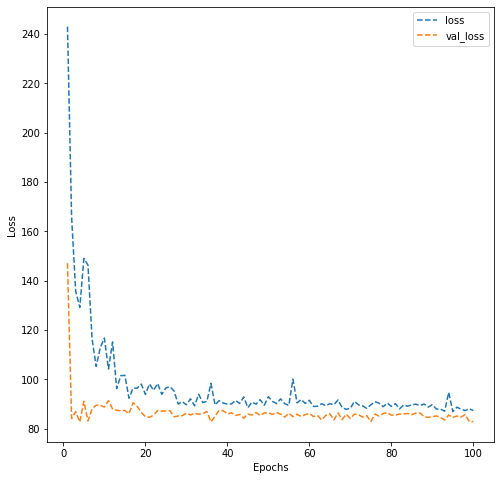

In [ ]:
# plotting the loss

dict_VGG16_hist = VGG16_model_hist.history
list_ep = [i for i in range(1,101)]

plt.figure(figsize = (8,8))
plt.plot(list_ep,dict_VGG16_hist['loss'],ls = '--', label = 'loss')
plt.plot(list_ep,dict_VGG16_hist['val_loss'],ls = '--', label = 'val_loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### Model predictions on test dataset

In [ ]:
VGG16_pred = VGG16_model.predict(X_test)

In [ ]:
#Display a random sample of 100 training images with associated labels
random.seed(10)
image_list = random.sample(range(0, X_test.shape[0]), 25)

plt.figure(figsize=(30, 30))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[image_list[i]], cmap=plt.cm.binary)
    label = "Target: " + str(y_test[image_list[i]]) + "\nPrediction: " + str(round(float(VGG16_pred[image_list[i]]),4))
    plt.xlabel(label , fontsize=22)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Save the model

In [ ]:
with open('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Models/Ensemble/11122021/Dict_VGG16_hist', 'wb') as file_pi:
  pickle.dump(dict_VGG16_hist, file_pi)

VGG16_model.save('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Models/Ensemble/11122021/VGG16.h5')

## **3.2 Efficient Model**

### Random set for reproduction

In [ ]:
backend.clear_session()

In [ ]:
np.random.seed(20)
random.seed(20)
tf.random.set_seed(20)

### Initialize the model

In [ ]:
Eff_model = EfficientNetB3(include_top=False, weights='imagenet')  #default drop_connect_rate is 0.2

### Build the model

In [ ]:
def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)
    model = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(1, activation="linear", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer, loss=LOSS, metrics=[MONITOR]
    )
    return model

In [ ]:
Eff_model = build_model()

In [ ]:
Eff_model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                       

### Fit the model

In [ ]:
Eff_model_hist = Eff_model.fit_generator(traindatagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                         steps_per_epoch=X_train.shape[0]/BATCH_SIZE,
                                         epochs=EPOCHS,
                                         validation_data=valdatagen.flow(X_val, y_val,batch_size=BATCH_SIZE), 
                                         validation_steps=X_val.shape[0]/BATCH_SIZE, 
                                         verbose=1)

Epoch 1/100
17/17 [==============================] - 50s 2s/step - loss: 295.7615 - mean_absolute_percentage_error: 295.7615 - val_loss: 108.1830 - val_mean_absolute_percentage_error: 108.1830
Epoch 2/100
17/17 [==============================] - 37s 2s/step - loss: 301.7263 - mean_absolute_percentage_error: 301.7263 - val_loss: 115.3544 - val_mean_absolute_percentage_error: 115.3544
Epoch 3/100
17/17 [==============================] - 36s 2s/step - loss: 294.4853 - mean_absolute_percentage_error: 294.4853 - val_loss: 120.7385 - val_mean_absolute_percentage_error: 120.7385
Epoch 4/100
17/17 [==============================] - 36s 2s/step - loss: 293.9886 - mean_absolute_percentage_error: 293.9886 - val_loss: 105.7220 - val_mean_absolute_percentage_error: 105.7220
Epoch 5/100
17/17 [==============================] - 36s 2s/step - loss: 269.3547 - mean_absolute_percentage_error: 269.3547 - val_loss: 109.9031 - val_mean_absolute_percentage_error: 109.9031
Epoch 6/100
17/17 [================

### Plotting model loss

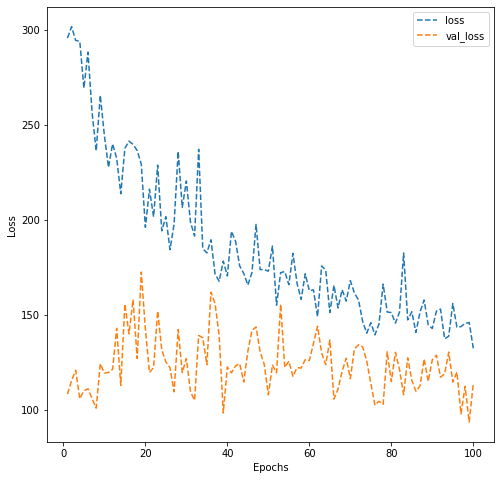

In [ ]:
# plotting loss

dict_hist = Eff_model_hist.history
list_ep = [i for i in range(1,101)]

plt.figure(figsize = (8,8))
plt.plot(list_ep,dict_hist['loss'],ls = '--', label = 'loss')
plt.plot(list_ep,dict_hist['val_loss'],ls = '--', label = 'val_loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### Model predictions on test dataset

In [ ]:
Eff_pred = Eff_model.predict(X_test)

In [ ]:
#Display a random sample of 100 training images with associated labels
random.seed(10)
image_list = random.sample(range(0, X_test.shape[0]), 25)

plt.figure(figsize=(30, 30))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[image_list[i]], cmap=plt.cm.binary)
    label = "Target: " + str(y_test[image_list[i]]) + "\nPrediction: " + str(round(float(Eff_pred[image_list[i]]),4))
    plt.xlabel(label , fontsize=22)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Save the model

In [ ]:
with open('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Models/Ensemble/11122021/Eff_model_hist', 'wb') as file_pi:
  pickle.dump(dict_hist, file_pi)

Eff_model.save('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Models/Ensemble/11122021/Eff.h5')

## **3.3 Convmixer Model**

### Random set for reproduction

In [ ]:
backend.clear_session()

In [ ]:
np.random.seed(30)
random.seed(30)
tf.random.set_seed(30)

### Initialize the model

In [ ]:

def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)


def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)


def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x


def get_conv_mixer_256_8(
    image_size=IMG_SIZE, filters=64, depth=8, kernel_size=10, patch_size=2, num_classes=1
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="linear")(x)

    return keras.Model(inputs, outputs)


### Build the model

In [ ]:
# Code reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/.


def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=LOSS,
        metrics=[MONITOR],
    )

    checkpoint_filepath = '/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Models/Ensemble/11122021/con_mix' 
    #"/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_mean_absolute_percentage_error",
        save_best_only=True,
    )

    #history = model.fit(
        #X_train, y_train,
        #validation_data=(X_val, y_val),
        #epochs=num_epochs,
        #batch_size=batch_size,
        #callbacks=[checkpoint_callback],
    #)

    history = model.fit_generator(
        traindatagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        steps_per_epoch=X_train.shape[0]/BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=valdatagen.flow(X_val, y_val,batch_size=BATCH_SIZE), 
        validation_steps=X_val.shape[0]/BATCH_SIZE, 
        callbacks=[checkpoint_callback],
        verbose=1
        )

    

    model.load_weights(checkpoint_filepath)
    #_, accuracy = model.evaluate(X_test, y_test,batch_size=BATCH_SIZE)
    #print(f"Test mean_absolute_percentage_error: {accuracy}")

    return history, model


### Fit the model

In [ ]:
conv_mixer_model = get_conv_mixer_256_8()
history, conv_mixer_model = run_experiment(conv_mixer_model)

In [ ]:
 conv_mixer_model.load_weights('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Models/Ensemble/11122021/con_mix')

### Plotting model loss

In [ ]:
# plotting the accuracies

conv_mix_hist = history.history
list_ep = [i for i in range(1,51)]

plt.figure(figsize = (8,8))
plt.plot(list_ep,dict_hist['mean_absolute_percentage_error'],ls = '--', label = 'loss')
plt.plot(list_ep,dict_hist['val_mean_absolute_percentage_error'],ls = '--', label = 'val_loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### Model predictions on test dataset

In [ ]:
conv_mixer_pred = conv_mixer_model.predict(X_test)

In [ ]:
#Display a random sample of 100 training images with associated labels
random.seed(10)
image_list = random.sample(range(0, X_test.shape[0]), 25)

plt.figure(figsize=(30, 30))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[image_list[i]], cmap=plt.cm.binary)
    label = "Target: " + str(y_test[image_list[i]]) + "\nPrediction: " + str(round(float(conv_mixer_pred[image_list[i]]),4))
    plt.xlabel(label , fontsize=22)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Save the model

In [ ]:
conv_mixer_model.save('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Models/Ensemble/11122021/con_mix/Conv_mixer_.h5')

## **3.4 Stacking Linear Regressors**

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [ ]:
estimators = [
              ('lr', RidgeCV()),
              ('svr', LinearSVR(random_state=42))
              ]

### **3.4.1 Stacking Linear Regressors on image dataset**

In [ ]:
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42
                                          )
    )

In [ ]:
d1, d2, d3, d4 = X_train.shape

In [ ]:
X_train_flat = X_train.reshape(d1, d2*d3*d4)

In [ ]:
dt1, dt2, dt3, dt4 = X_test.shape

In [ ]:
X_test_flat = X_test.reshape(dt1, dt2*dt3*dt4)

In [ ]:
reg.fit(X_train_flat, y_train)

StackingRegressor(estimators=[('lr', RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('svr', LinearSVR(random_state=42))],
                  final_estimator=RandomForestRegressor(n_estimators=10,
                                                        random_state=42))

In [ ]:
# save the model to disk
filename = '/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Models/Ensemble/11122021/reg_model.sav'
pickle.dump(reg, open(filename, 'wb'))

In [ ]:
reg.score(X_test_flat, y_test)

-0.14288788407510356

### **3.4.2 Stacking Linear Regressors on metadata**

####Build the model

In [ ]:
reg_meta = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42
                                          )
    )

####Train the model

In [ ]:
reg_meta.fit(meta_df_X_train, meta_df_y_train)

StackingRegressor(estimators=[('lr', RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('svr', LinearSVR(random_state=42))],
                  final_estimator=RandomForestRegressor(n_estimators=10,
                                                        random_state=42))

####Save the model

In [ ]:
# save the model to disk
file = '/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Models/Ensemble/11122021/reg_meta_model.sav'
pickle.dump(reg_meta, open(file, 'wb'))

####Evaluate the model

In [ ]:
reg_meta.score(meta_df_X_test, meta_df_y_test)

-0.1136283485031826

# **4. Models Evaluation and weighting**

## **Load models & Test data**

In [ ]:
# load the models from disk
l_reg_model = pickle.load(open('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Models/Ensemble/11122021/reg_model.sav', 'rb'))
l_reg_meta_model = pickle.load(open('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Models/Ensemble/11122021/reg_meta_model.sav', 'rb'))
l_VGG16_model = load_model('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Models/Ensemble/11122021/VGG16.h5')
l_Eff_model = load_model('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Models/Ensemble/11122021/Eff.h5')
l_ConvMix_model = load_model('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Models/Ensemble/11122021/con_mix/Conv_mixer_.h5')

In [ ]:
X_test_np =np.load('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Dataset/Numpy_224px_11122021/X_test_224.npy')
y_test_np =np.load('/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Prediction_Model/Dataset/Numpy_224px_11122021/y_test_224.npy')

## **Evaluate models**

In [ ]:
VGG16_score = l_VGG16_model.evaluate(X_test_np, y_test_np)
Eff_score = l_Eff_model.evaluate(X_test_np, y_test_np)
ConvMix_score = l_ConvMix_model.evaluate(X_test_np, y_test_np)
Reg_score = l_reg_model.score(X_test_np.reshape(X_test_np.shape[0], X_test_np.shape[1]*X_test_np.shape[2]*X_test_np.shape[3]), y_test_np)                 
Meta_reg_score = reg_meta.score(X_test, y_test)      

5/5 [==============================] - 5s 1s/step - loss: 94.4047 - mean_absolute_percentage_error: 94.4047


In [ ]:
print("VGG16 Score: ", round(VGG16_score[0],2))
print("EffecientNet Score: ",  round(Eff_score[0],2))
print("Con_mixer Score: ",  round(ConvMix_score[0],2))
print("Stacked Regressors (Images) Score: ",  round(Reg_score,2))
print("Stacked Regressors (Meta) Score: ",  round(Meta_reg_score,2))

VGG16 Score:  92.82
EffecientNet Score:  137.89
Con_mixer Score:  94.4
Stacked Regressors (Images) Score:  -0.14
Stacked Regressors (Meta) Score:  -0.11


To get wieghted average across models, we define weights below based on observed results of models evaluation above

In [ ]:
weights = [0.4, 0.1, 0.4, 0.05, 0.05]

# **5. Model predictions on generated art**

In [ ]:
images = []
images_names = []
path = '/content/drive/MyDrive/AI_Artathon/Phase_2/Models/Generation_Model/StyleGAN2/stylegan2-ada-pytorch/results/00000-SuperRare_PIL_1024_RGB-mirror-11gb-gpu-gamma50-bg-resumecustom/Selected/1024px/'
images_path = os.listdir(path)
for i, image_name in enumerate(images_path):
  image = Image.open(path+image_name)
  image = image.resize((224, 224)).convert("RGB")
  images.append(np.array(image))
  images_names.append(image_name)
images = np.array(images)
images_names = np.array(images_names)

In [ ]:
images_names

array(['seed0185.png', 'seed0284.png', 'seed0301.png', 'seed0425.png',
       'seed0459.png', 'seed0336.png', 'seed0341.png', 'seed0279.png',
       'seed0298.png', 'seed0333.png'], dtype='<U12')

In [ ]:
l_VGG16_pred = l_VGG16_model.predict(images)
l_Eff_pred = l_Eff_model.predict(images)
l_ConvMix_pred = l_ConvMix_model.predict(images)
l_reg_pred = l_reg_model.predict(images.reshape(images.shape[0], images.shape[1]*images.shape[2]*images.shape[3]))
#Skipped meta data predictor for sake of simplicity now           

In [ ]:
for i, image in enumerate(images_names):
  print(image,": ", round(float(l_VGG16_pred[i])*0.4 + float(l_Eff_pred[i])*0.1 + float(l_ConvMix_pred[i])*0.4 + float(l_reg_pred[i])*0.1,2))

seed0185.png :  0.24
seed0284.png :  0.53
seed0301.png :  7.44
seed0425.png :  0.3
seed0459.png :  0.43
seed0336.png :  7.32
seed0341.png :  0.31
seed0279.png :  0.43
seed0298.png :  0.33
seed0333.png :  0.43
